# Comparison between SMC-ABC and SNPE in GLM model

In [29]:
import delfi.distribution as dd
import delfi.generator as dg
import delfi.inference as infer
import delfi.utils.io as io
import delfi.summarystats as ds
import lfimodels.glm.utils as utils
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scripts.run_abc as run_abc

from delfi.utils.viz import plot_pdf
from lfimodels.glm.GLM import GLM
from lfimodels.glm.GLMStats import GLMStats
from mpl_toolkits.axes_grid1 import make_axes_locatable
from random import sample
from scripts.mmd import MMD_3_Sample_Test

%matplotlib inline
%run -i common.ipynb

dirs = {}
dirs['dir_glm'] = './results/glm/'
dirs['dir_pg'] = './results/pg/'
dirs['dir_abc'] = './results/abc/'

# number of algorithms compared
n_algos = 2


# FIGURE AND GRID
FIG_HEIGHT_MM = 90
FIG_WIDTH_MM = FIG_WIDTH_MM  # set in NIPS2017 notebook to a default value for all figures
FIG_N_ROWS = 2
ROW_1_NCOLS = 1
ROW_1_HEIGHT_MM = FIG_HEIGHT_MM / FIG_N_ROWS
ROW_1_WIDTH_COL_1_MM = FIG_WIDTH_MM / ROW_1_NCOLS
ROW_2_NCOLS = 1
ROW_2_HEIGHT_MM = FIG_HEIGHT_MM / FIG_N_ROWS
ROW_2_WIDTH_COL_1_MM = FIG_WIDTH_MM / ROW_2_NCOLS

PATH_DROPBOX_FIGS = PATH_DROPBOX + 'figs/'

# PATHS
PANEL_A = PATH_DROPBOX_FIGS + 'supp_fig_smccompare_a.svg'
PANEL_B = PATH_DROPBOX_FIGS + 'supp_fig_smccompare_b.svg'

## GLM model

In [3]:
seed = 42

m = GLM(seed=seed)
p = utils.smoothing_prior(n_params=m.n_params, seed=seed)
s = GLMStats(n_summary=m.n_params)
g = dg.Default(model=m, prior=p, summary=s)

true_params, labels_params = utils.obs_params()
obs = utils.obs_data(true_params, seed=seed)
obs_stats = utils.obs_stats(true_params, seed=seed)

n_params = len(true_params)
prefix = str(n_params)+'params'

# Load posteriors (1 seed, one set of hyperparameters)

## SNPE

In [11]:
n_rounds = 5
round_samp = 5000
num_sims_max = round_samp*n_rounds
n_samps = np.arange(round_samp,num_sims_max+round_samp,round_samp)

m_snpe = []
S_snpe = []

rerun = False  # if False, will try loading file from disk

try:
    assert rerun == False, 'rerun requested'
#     _, _, posteriors = io.load_pkl(dirs['dir_glm'] + prefix + '_' + str(n_rounds) +'rounds_nosvi_snpe.pkl')
    posteriors = io.load_pkl(dirs['dir_glm'] + 'glm_posterior.pkl')
except:    
    seed = 1
    g = dg.Default(model=m, prior=p, summary=s)
    res = infer.SNPE(g, obs=obs_stats, pilot_samples=1000, n_hiddens=[50], seed=seed, prior_norm=True, svi=False)

    # run with N samples
    logs, trn_datasets, posteriors = res.run(round_samp, n_rounds=n_rounds, epochs=1000)
    io.save_pkl((logs, trn_datasets, posteriors),
                dirs['dir_glm'] + prefix + '_' + str(n_rounds) + 'rounds_nosvi_snpe.pkl')
    io.save(res, dirs['dir_glm'] + prefix + '_' + str(n_rounds) + 'rounds_res_nosvi_snpe.pkl')

# for i in range(n_rounds):
#     m1, S1 = posteriors[i].calc_mean_and_cov()
#     m_snpe.append(m1)
#     S_snpe.append(S1)
m1, S1 = posteriors.calc_mean_and_cov()
m_snpe.append(m1)
S_snpe.append(S1)

## PG-MCMC

In [16]:
rerun = False  # if False, will try loading file from disk

try:
    assert rerun == False, 'rerun requested'
#     sam_pg = np.load(dirs['dir_pg'] + prefix + '_pg_mcmc.npz')['arr_0']
    sam_pg = np.load(dirs['dir_pg'] + 'sam.npz')['arr_0']
except:
    sam_pg = utils.pg_mcmc(true_params, obs, seed=None)
    np.savez(dirs['dir_pg'] + prefix + '_pg_mcmc.npz', sam_pg)

m_sam = np.mean(sam_pg,axis=1)
cov_sam = np.cov(sam_pg)

## SMC-ABC

In [13]:
rerun = False  # if False, will try loading file from disk

try:
    assert rerun == False, 'rerun requested'
#     ps_smc, logweights_smc, eps_smc, all_nsims_smc = io.load_pkl(dirs['dir_abc'] + prefix + '_smc_abc.pkl')
    ps_smc, logweights_smc, eps_smc, all_nsims_smc = io.load_pkl(dirs['dir_abc'] + 'new_smc_abc.pkl')
except:
    ps_smc, logweights_smc, eps_smc, all_nsims_smc = run_abc.run_smc(model=m, prior=p, summary=s,
                                                                                  obs_stats=obs_stats,
                                                                                  n_params=n_params, seed=None, 
                                                                                  n_particles=1e3,eps_init=15,
                                                                                  maxsim=5e6)
#     io.save_pkl((ps_smc, logweights_smc, eps_smc, all_nsims_smc), dirs['dir_abc'] + prefix + '_smc_abc.pkl')
    io.save_pkl((ps_smc, logweights_smc, eps_smc, all_nsims_smc), dirs['dir_abc'] + 'new_smc_abc.pkl')

weights_smc = np.exp(logweights_smc)
nsims_smc = np.asarray(all_nsims_smc)

m_smc = []
cov_smc = []
for i in range(len(ps_smc)):
    m_smc.append(np.dot(weights_smc[i],ps_smc[i]))
    cov_smc.append(np.cov(ps_smc[i].T,aweights = weights_smc[i]))

## Number of simulations

In [21]:
all_n_sims = [n_samps,nsims_smc]

In [22]:
all_n_sims

[array([ 5000, 10000, 15000, 20000, 25000]), array([4477750, 4497912])]

## Plot means and variances

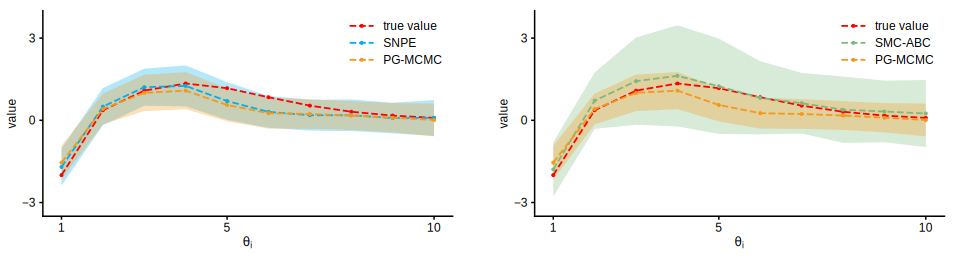

In [30]:
# f, axs = plt.subplots(1,n_algos,figsize=(20,5))

COL['SMC'] = (125/255, 185/255, 125/255)

all_m = [m_snpe,m_smc]
all_cov = [S_snpe,cov_smc]
all_col = [COL['SNPE'],COL['SMC']]
all_label = ['SNPE','SMC-ABC']

# matplotlib takes figsize specified as inches
# in NIPS2016 SCALE_IN and the conversion function are defined
fig_inches = (SCALE_IN*mm2inches(1.14*ROW_1_WIDTH_COL_1_MM), SCALE_IN*mm2inches(0.93*ROW_1_HEIGHT_MM))

with mpl.rc_context(fname=MPL_RC):
    plt.figure(figsize=fig_inches)

    for i in range(n_algos):
        plt.subplot(1,n_algos,i+1)
        plt.fill_between(np.linspace(1, n_params, n_params), 
                         all_m[i][-1]-2*np.sqrt(np.diag(all_cov[i][-1])),
                         all_m[i][-1]+2*np.sqrt(np.diag(all_cov[i][-1])), 
                         facecolor=all_col[i], 
                         alpha=0.3)
        plt.fill_between(np.linspace(1,n_params,n_params), 
                         m_sam-2*np.sqrt(np.diag(cov_sam)),
                         m_sam+2*np.sqrt(np.diag(cov_sam)), 
                         facecolor=COL['ESS'], 
                         alpha=0.3)
        plt.plot(np.linspace(1,n_params,n_params), 
                 true_params, '--o', color = 'r', label='true value')
        plt.plot(np.linspace(1,n_params,n_params), 
                 all_m[i][-1], '--o', color = all_col[i], label=all_label[i])
        plt.plot(np.linspace(1,n_params,n_params),
                 m_sam, '--o', color = COL['ESS'],
                 label='PG-MCMC')

        plt.gca().set_xticks([1, n_params/2, n_params])
        plt.gca().set_yticks([-3, 0, 3])
        plt.ylim(-3.5, 4)
        plt.xlabel(r'$\theta_i$')
        plt.ylabel('value')
        plt.legend()
        
    plt.savefig(PANEL_A, facecolor=plt.gcf().get_facecolor(), transparent=True)  # the figure is saved as svg
    plt.close()

svg(PANEL_A)

## Plot covariances

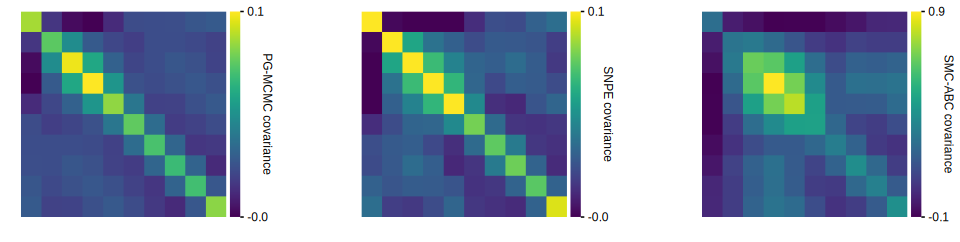

In [31]:
# min_cov = np.min([np.min(l) for l in all_cov])
# max_cov = np.max([np.max(l) for l in all_cov])
min_cov = [np.min(cov_sam),np.min(all_cov[1][-1])]
max_cov = [np.max(cov_sam),np.max(all_cov[1][-1])]

# f, axs = plt.subplots(1,n_algos,figsize=(20,5))

# matplotlib takes figsize specified as inches
# in NIPS2016 SCALE_IN and the conversion function are defined
fig_inches = (SCALE_IN*mm2inches(1.22*ROW_2_WIDTH_COL_1_MM), SCALE_IN*mm2inches(0.93*ROW_2_HEIGHT_MM))

with mpl.rc_context(fname=MPL_RC):
    
    plt.figure(figsize=fig_inches)

    ax = plt.subplot(1,n_algos+1,1)
    im = plt.imshow(cov_sam, clim=(min_cov[0], max_cov[0]))
    plt.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb = plt.colorbar(im, cax=cax)
    cb.set_label('PG-MCMC covariance', rotation=270)
    cb.set_clim([min_cov[0], max_cov[0]])
    cb.set_ticks([min_cov[0], max_cov[0]])
    cb.outline.set_visible(False)
    cb.set_ticklabels([str(np.round(min_cov[0], 1)), str(np.round(max_cov[0], 1))])

    for i in range(n_algos):
        ax = plt.subplot(1,n_algos+1,i+2)
        im = plt.imshow(all_cov[i][-1], clim=(min_cov[i], max_cov[i]))
        plt.axis('off')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cb = plt.colorbar(im, cax=cax)
        cb.set_label(all_label[i]+' covariance', rotation=270)
        cb.set_clim([min_cov[i], max_cov[i]])
        cb.set_ticks([min_cov[i], max_cov[i]])
        cb.outline.set_visible(False)
        cb.set_ticklabels([str(np.round(min_cov[i], 1)), str(np.round(max_cov[i], 1))])
    
    plt.savefig(PANEL_B, facecolor=plt.gcf().get_facecolor(), transparent=True)  # the figure is saved as svg
    plt.close()

svg(PANEL_B)

## Compose figure

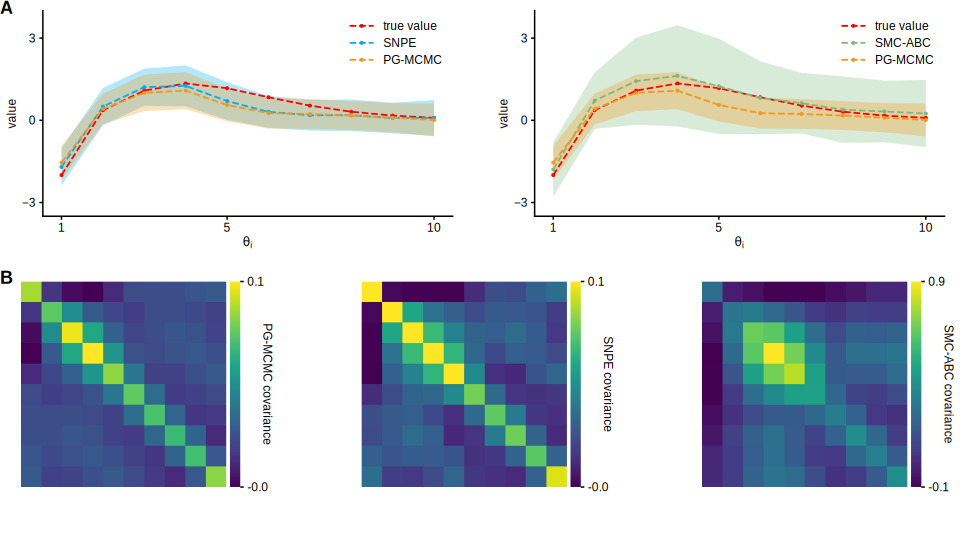

In [32]:
fig = create_fig(FIG_WIDTH_MM, FIG_HEIGHT_MM)

fig = add_svg(fig, PANEL_A, 0, 0)
fig = add_svg(fig, PANEL_B, 0, ROW_2_HEIGHT_MM)

fig = add_label(fig, 'A', 0*160/2, 2.3)
fig = add_label(fig, 'B', 0*160/2, ROW_2_HEIGHT_MM + 2.3)


if False:  # set to False to disable grid
    fig = add_grid(fig, 2, 2)
    fig = add_grid(fig, 2, 2)

PATH_SVG = PATH_DROPBOX_FIGS + 'supp_fig_smccompare.svg'
fig.save(PATH_SVG)

svg(PATH_SVG)

!$INKSCAPE --export-pdf $PATH_DROPBOX_FIGS/supp_fig_smccompare.pdf $PATH_SVG